NOTES:
The main issue here is that we don't know what test to do to compute the differece between a state's ranking vs how the other states rank. (Mann whitney U?)
The last graph looks "promising" but why all values are significant for all states makes no sense. (red vs blue)
Should we look simply whether there is a is statistical difference in average rating for the states? (not just whether it is higher than how other people score it)

Q1: Do Californians prefer Californian beer over non Californians? (Its for all US states but just for question focus purposes)
This question is for BeerAdvocate data which we established before has a lot of data on US states.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [10]:
#rankings data with beer_location and user_location added as extra columns
BA_merged = pd.read_csv('../../minimizedData/BA_ratings_small_plus.csv')

In [11]:
BA_merged.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"United States, Washington",2.88,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,"United States, New York",3.85,Northern Ireland


In [12]:
print(BA_merged.shape)
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
print(US_ratings.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]

US_ratings.head(2)

(8393032, 15)
(7892754, 15)


,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.5,4.00,4.0,3.75,3.75,3.76,"United States, North Carolina",3.76,"United States, Wisconsin"
1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.0,3.75,4.0,3.50,3.50,3.58,"United States, North Carolina",3.58,"United States, Wisconsin"


In [13]:
#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]


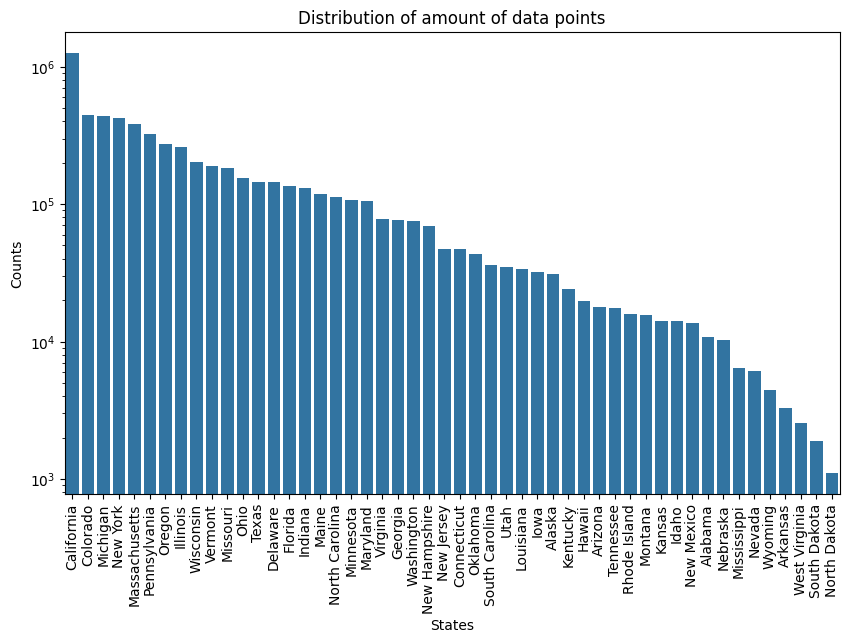

In [14]:
counts = US_ratings.groupby(['beer_state'])['avg'].count()
counts = counts.sort_values(ascending=False)
#histogram of the average ratings
plt.figure(figsize=(10, 6))
sns.barplot(counts)
plt.title("Distribution of amount of data points")
plt.xlabel("States")
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel("Counts")
plt.show()


In [15]:
#Average rating of all users by state for all states
#Mean calculated by grouping rankings by user_state and beer_state

state_ratings = US_ratings.groupby(['user_state', 'beer_state'])['avg'].mean().reset_index()
state_ratings.head(2)

,user_state,beer_state,avg
0,Alabama,Alabama,3.842899
1,Alabama,Alaska,3.852717


In [16]:
#create matrix which gives the avg rating of each beers of state to user of state combination pair
#ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg')
state_ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg', fill_value=0)
state_ratings_matrix.head(2)

beer_state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
user_state,,,,,,,,,,,,,,,,,,,,,
Alabama,3.842899,3.852717,3.240513,3.717222,3.991335,3.772443,4.045263,3.949393,3.831054,3.831031,...,3.746667,3.765035,3.655649,3.656977,3.801226,3.690347,3.681420,3.747143,3.390454,3.908
Alaska,3.809091,3.908503,3.763333,3.480000,4.029584,3.872363,4.036000,3.965247,3.948252,3.872750,...,3.587500,3.740000,3.842672,3.915357,4.098214,3.800000,3.825049,3.430000,3.534313,4.104


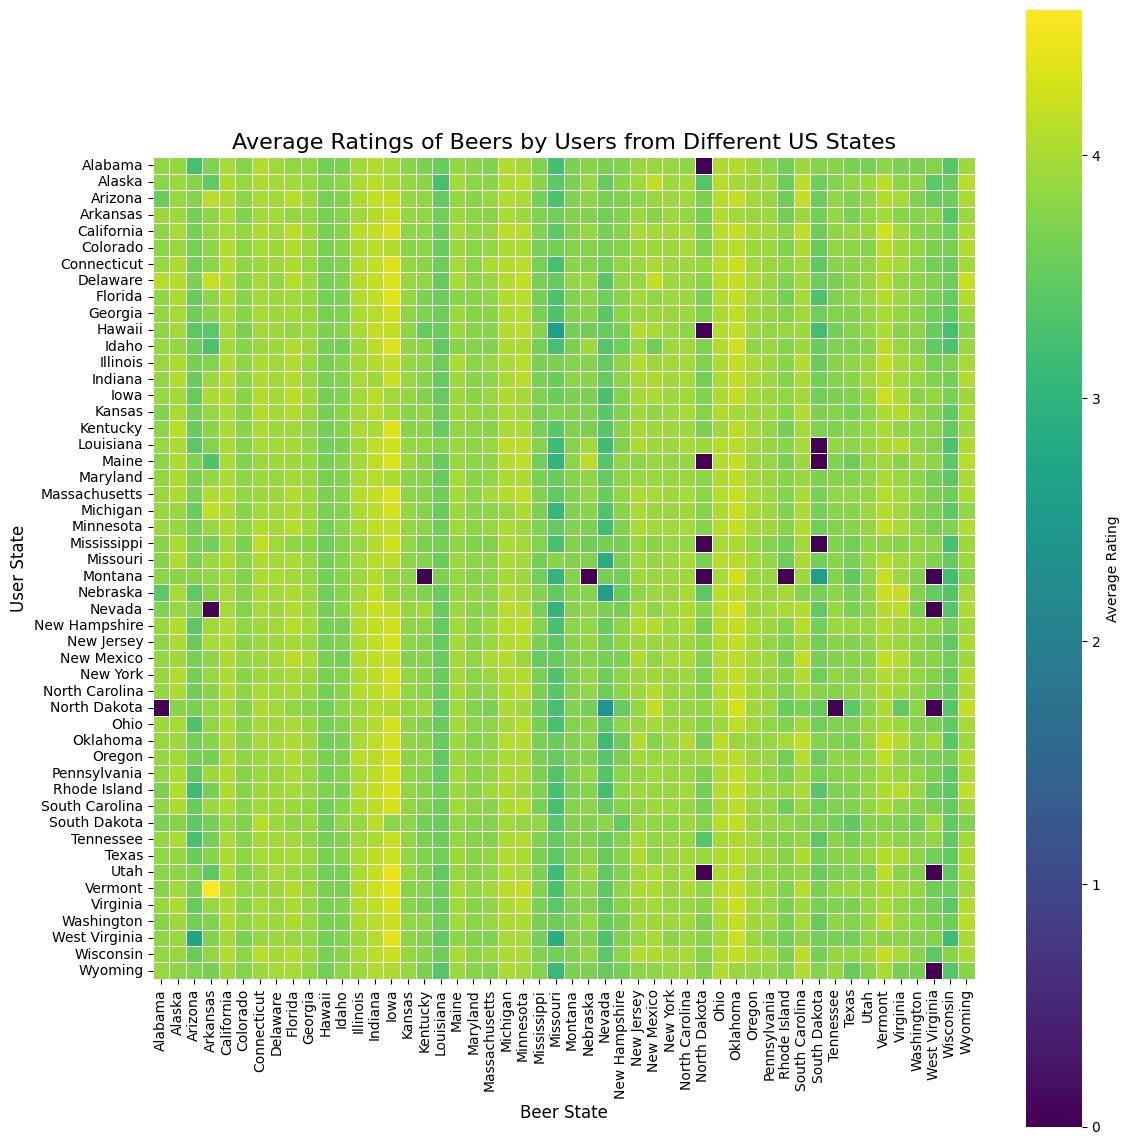

In [17]:
plt.figure(figsize=(12, 12))

sns.heatmap(state_ratings_matrix, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Average Rating'}, square=True)

plt.title('Average Ratings of Beers by Users from Different US States', fontsize=16)
plt.xlabel('Beer State', fontsize=12)
plt.ylabel('User State', fontsize=12)
plt.tight_layout()

plt.show()


There are several problems here: when there are no ratings we need to put Nan not 0.

Below we are comparing the difference between the average ratings for the beers in the state compared to the average rating given by all other 49 states.

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/1064256621.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(


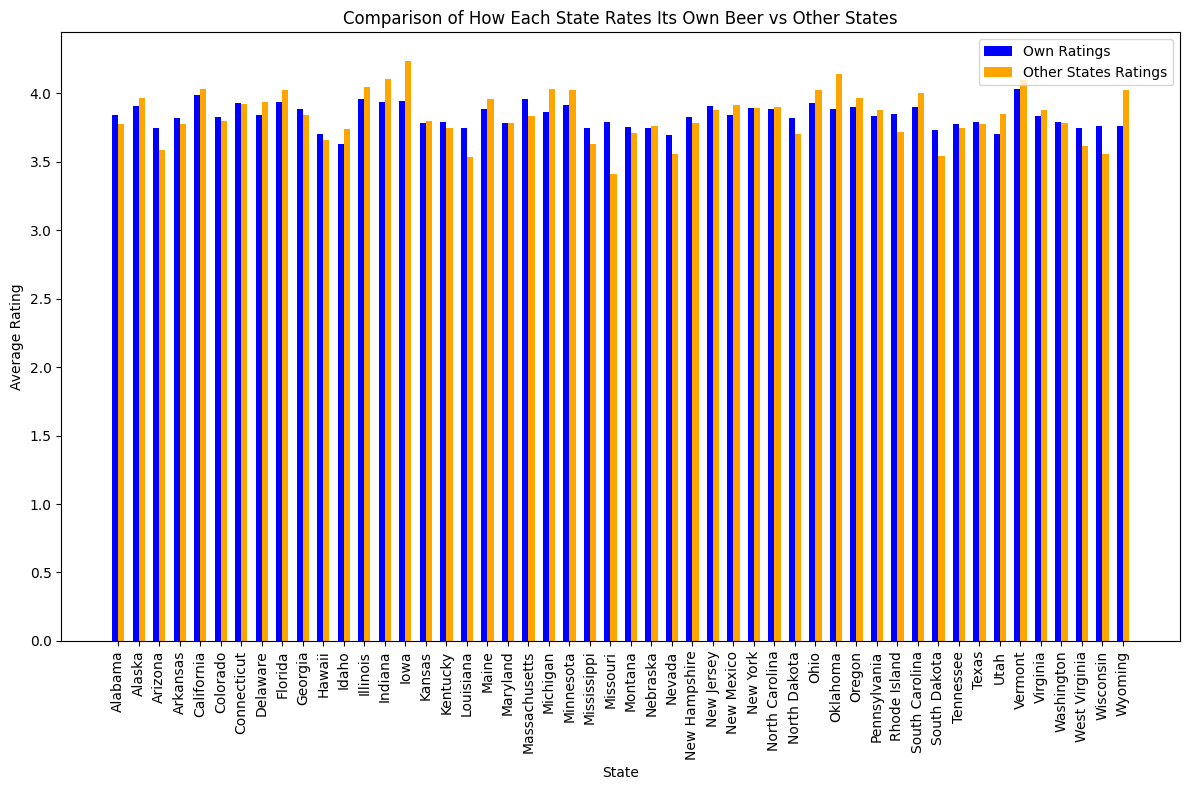

In [18]:
#average ratings for each state when rating its own beer
own_beer_ratings = US_ratings[US_ratings['user_state'] == US_ratings['beer_state']].groupby('beer_state')['avg'].mean()

#total number of ratings per beer_state
total_ratings_per_state = US_ratings.groupby('beer_state').size()

#weighted average rating for each beer by other states
other_state_ratings = US_ratings[US_ratings['user_state'] != US_ratings['beer_state']]
other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(
    lambda group: np.average(group['rating'], weights=group['user_state'].map(total_ratings_per_state))
)

ratings_comparison = pd.DataFrame({
    'own_beer_avg': own_beer_ratings,
    'other_states_avg': other_state_avg_ratings
})

ratings_comparison['other_states_avg'] = ratings_comparison['other_states_avg'].fillna(0)
plt.figure(figsize=(12, 8))

bar_width = 0.3
index = np.arange(len(ratings_comparison)) 

#allows us to place the bars next to each other
plt.bar(index - bar_width / 2, ratings_comparison['own_beer_avg'], bar_width, label='Own Ratings', color='blue')
plt.bar(index + bar_width / 2, ratings_comparison['other_states_avg'], bar_width, label='Other States Ratings', color='orange')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of How Each State Rates Its Own Beer vs Other States')
plt.xticks(index, ratings_comparison.index, rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/897117608.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]],


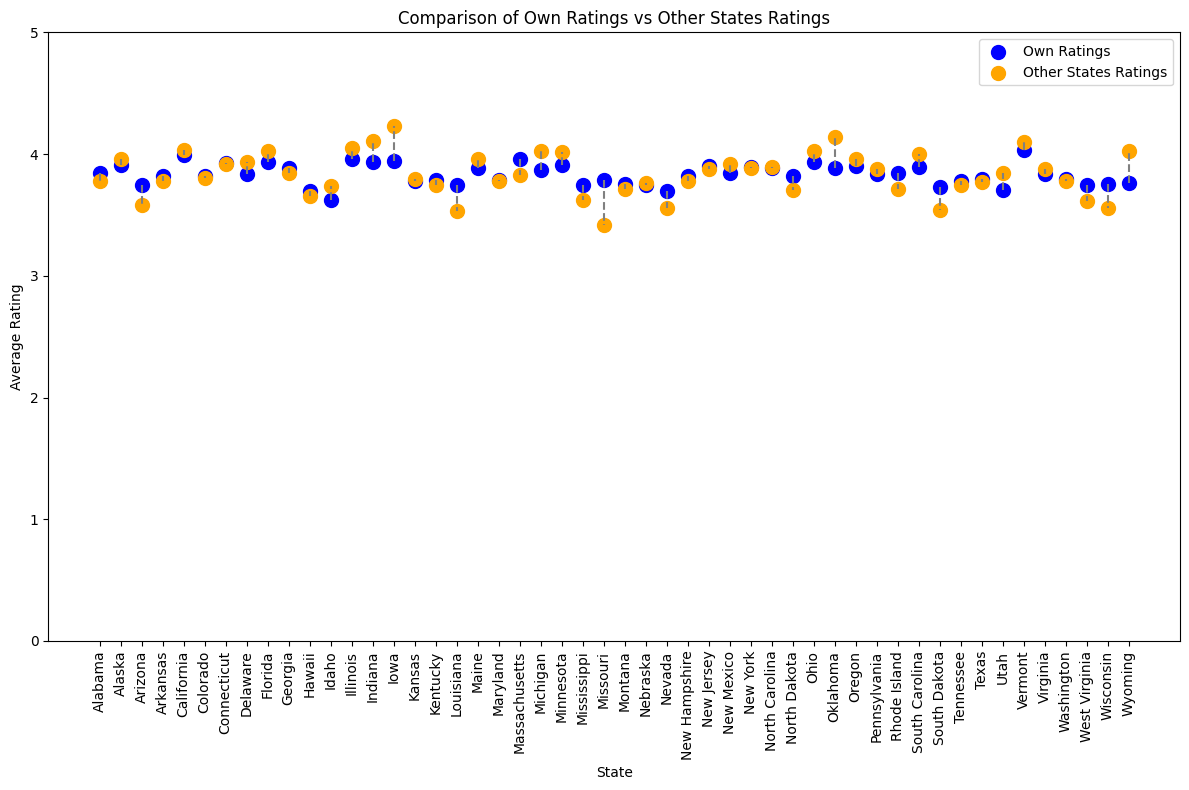

In [19]:
plt.figure(figsize=(12, 8))

#dots for better visibility
plt.scatter(ratings_comparison.index, ratings_comparison['own_beer_avg'], label='Own Ratings', color='blue', s=100, zorder=2)
plt.scatter(ratings_comparison.index, ratings_comparison['other_states_avg'], label='Other States Ratings', color='orange', s=100, zorder=2)

#lines connecting the dots for visibility
for i in range(len(ratings_comparison)):
    plt.plot([ratings_comparison.index[i], ratings_comparison.index[i]], 
             [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]], 
             color='gray', linestyle='--')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of Own Ratings vs Other States Ratings')
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()

plt.show()


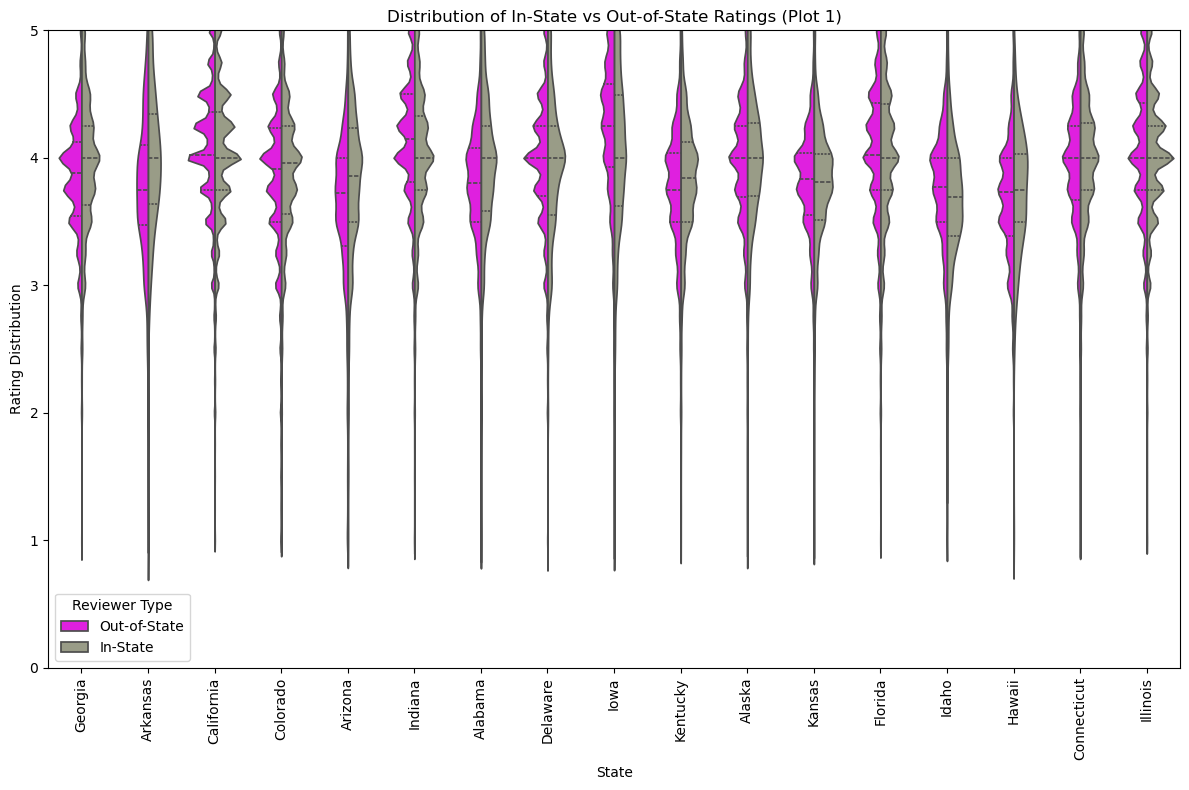

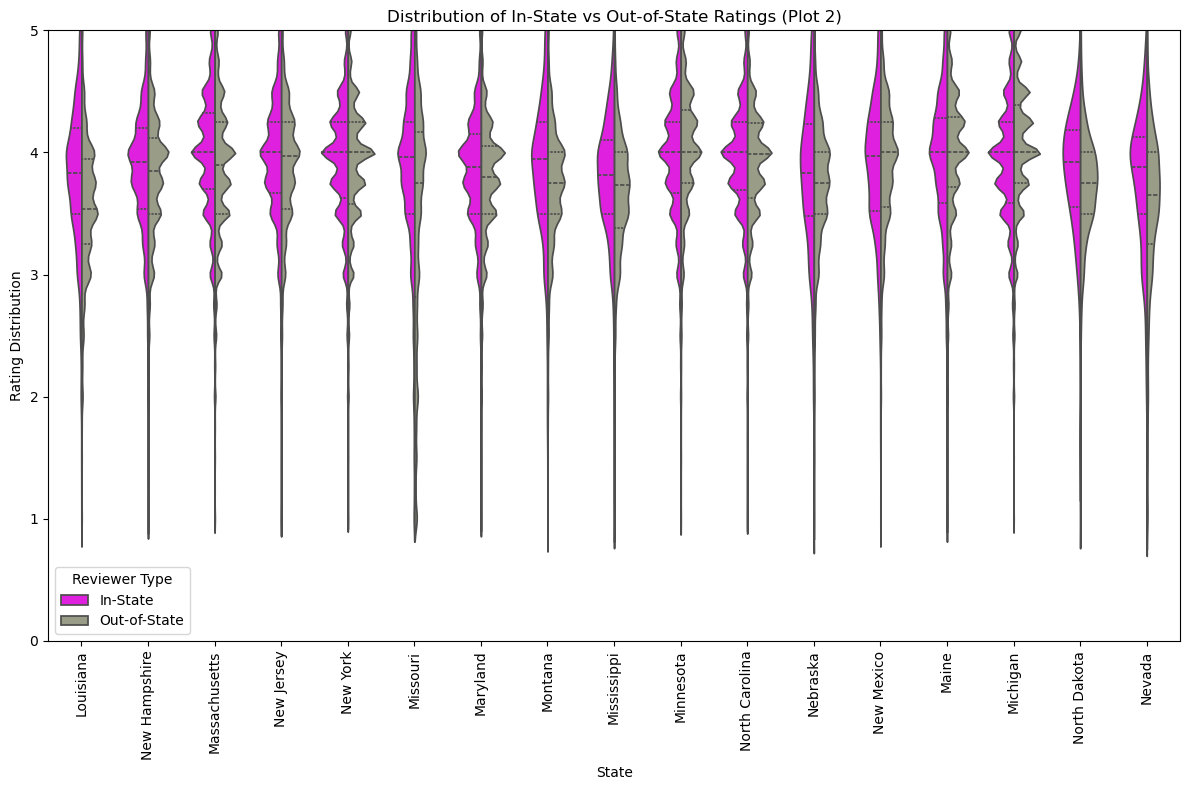

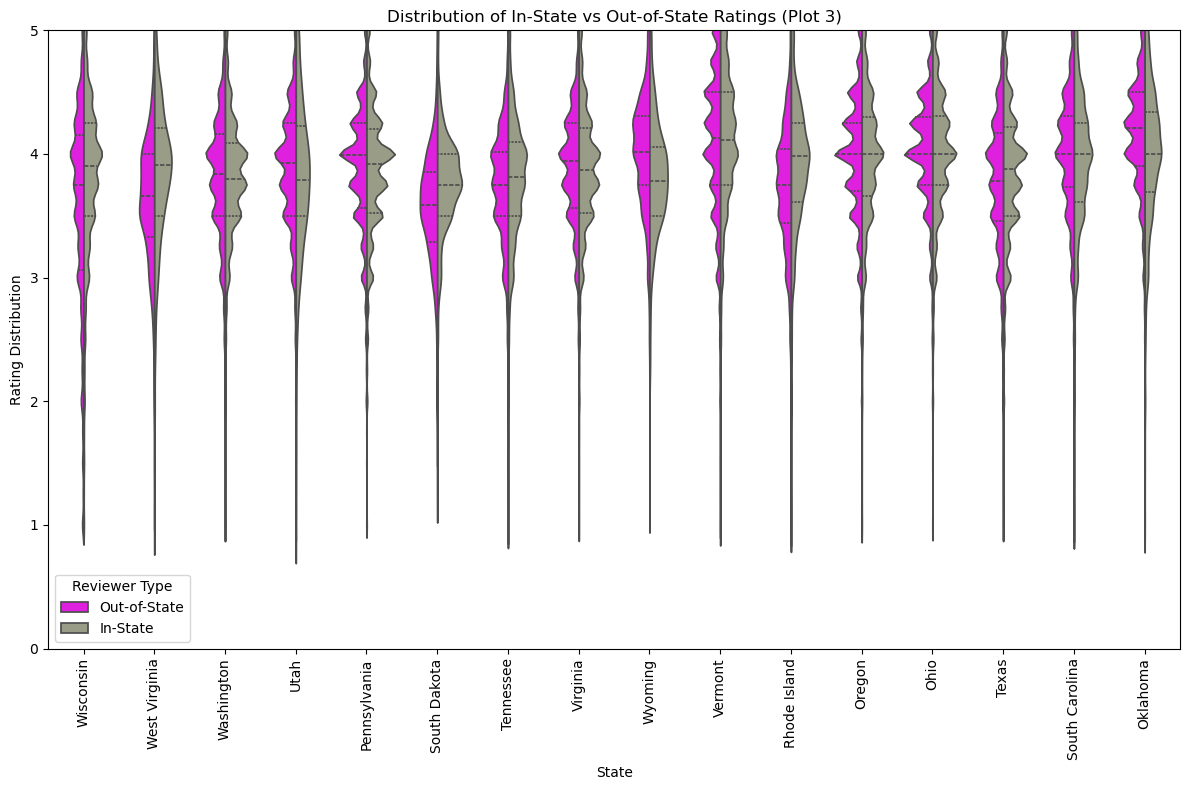

In [20]:
import math

US_ratings['state_IN_VS_OUT'] = np.where(
    US_ratings['user_state'] == US_ratings['beer_state'], 
    'In-State', 
    'Out-of-State'
)

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()  

num_figures = 3  
num_states = len(unique_states)
states_per_figure = math.ceil(num_states / num_figures)

custom_palette = ['magenta', '#9c9f84'] 

for i in range(num_figures):
    start_idx = i * states_per_figure
    end_idx = min((i + 1) * states_per_figure, num_states)
    subset_states = unique_states[start_idx:end_idx]
    
    subset_data = US_ratings[US_ratings['beer_state'].isin(subset_states)]
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        x='beer_state', 
        y='rating', 
        hue='state_IN_VS_OUT', 
        data=subset_data, 
        palette=custom_palette, 
        split=True, 
        inner='quartile'
    )

    plt.xlabel('State')
    plt.ylabel('Rating Distribution')
    plt.title(f'Distribution of In-State vs Out-of-State Ratings (Plot {i+1})')
    plt.xticks(rotation=90)
    plt.ylim(0, 5)
    plt.legend(title='Reviewer Type')
    plt.tight_layout()
    plt.show()



/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/4153175424.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


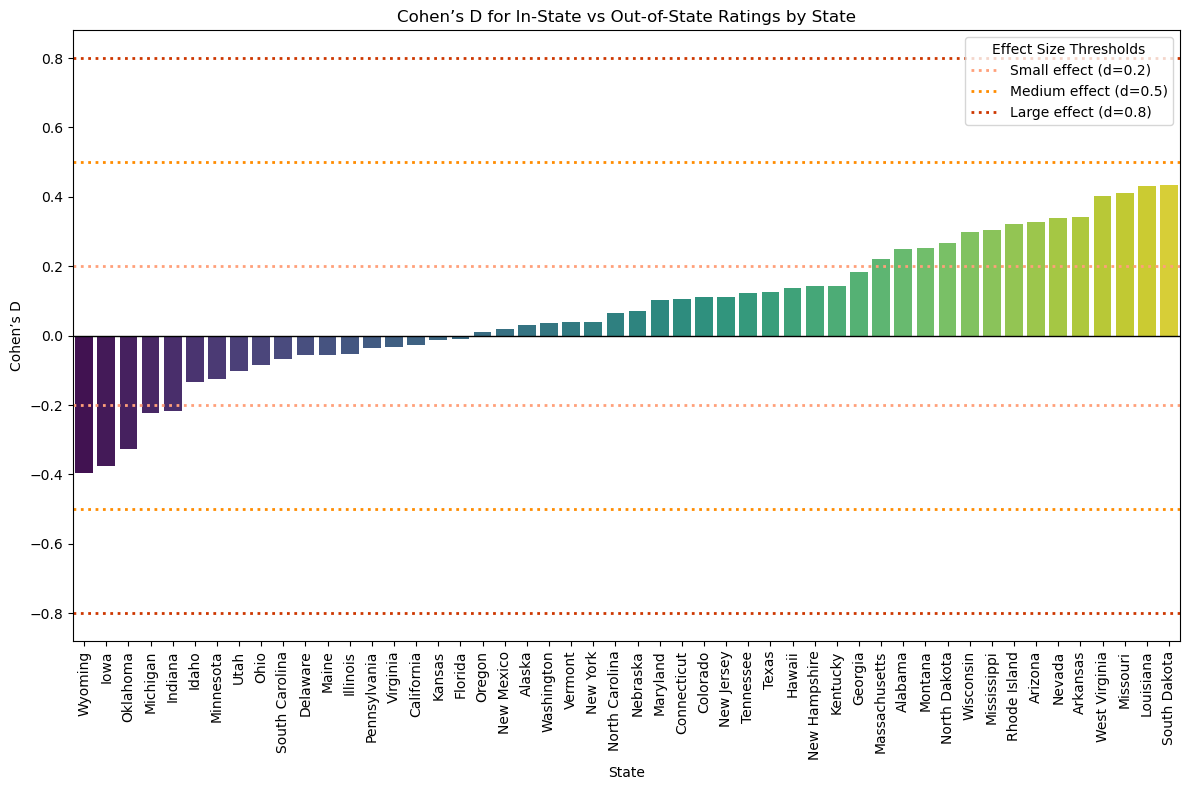

In [21]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Optional: sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()

plt.figure(figsize=(12, 8))

sns.barplot(
    x=cohen_df_no_nan.index, 
    y='Cohen_d', 
    data=cohen_df_no_nan, 
    palette='viridis'
)

plt.axhline(y=0, color='black', linewidth=1)

plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)

plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State')

plt.xticks(rotation=90)

plt.legend(title='Effect Size Thresholds', loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/475010455.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


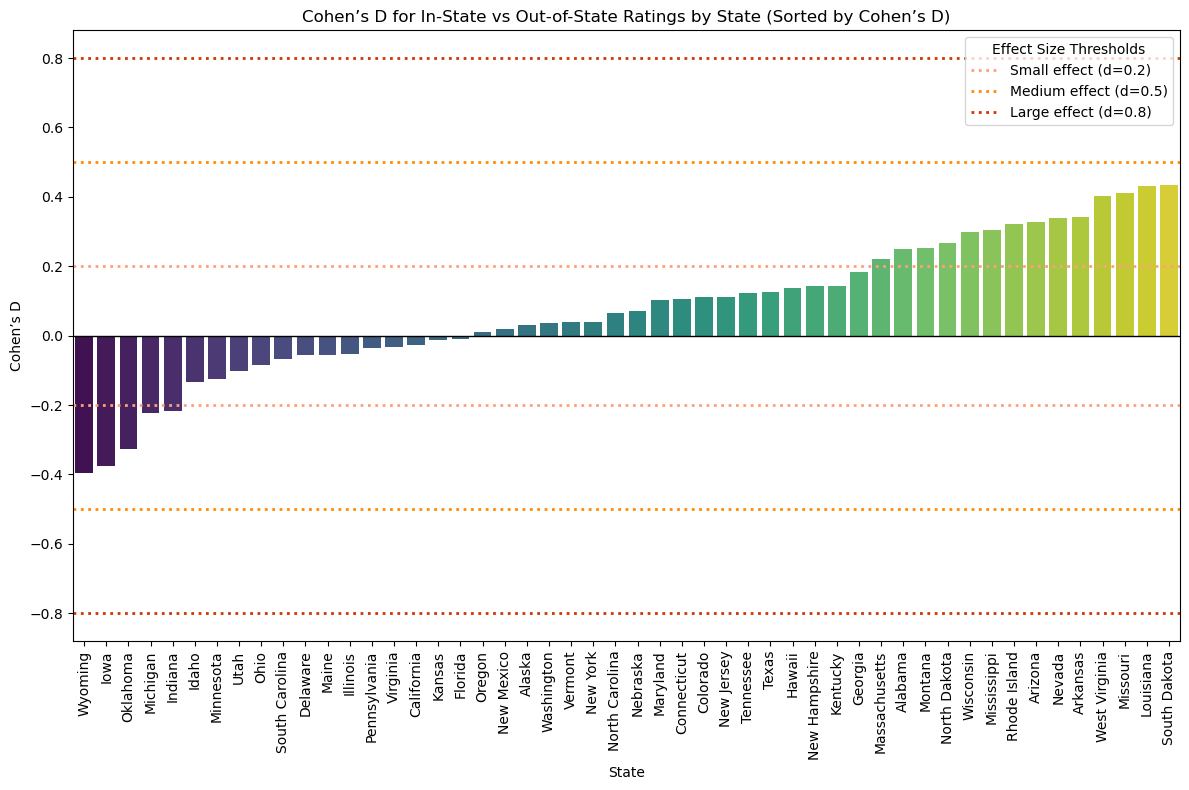

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/475010455.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


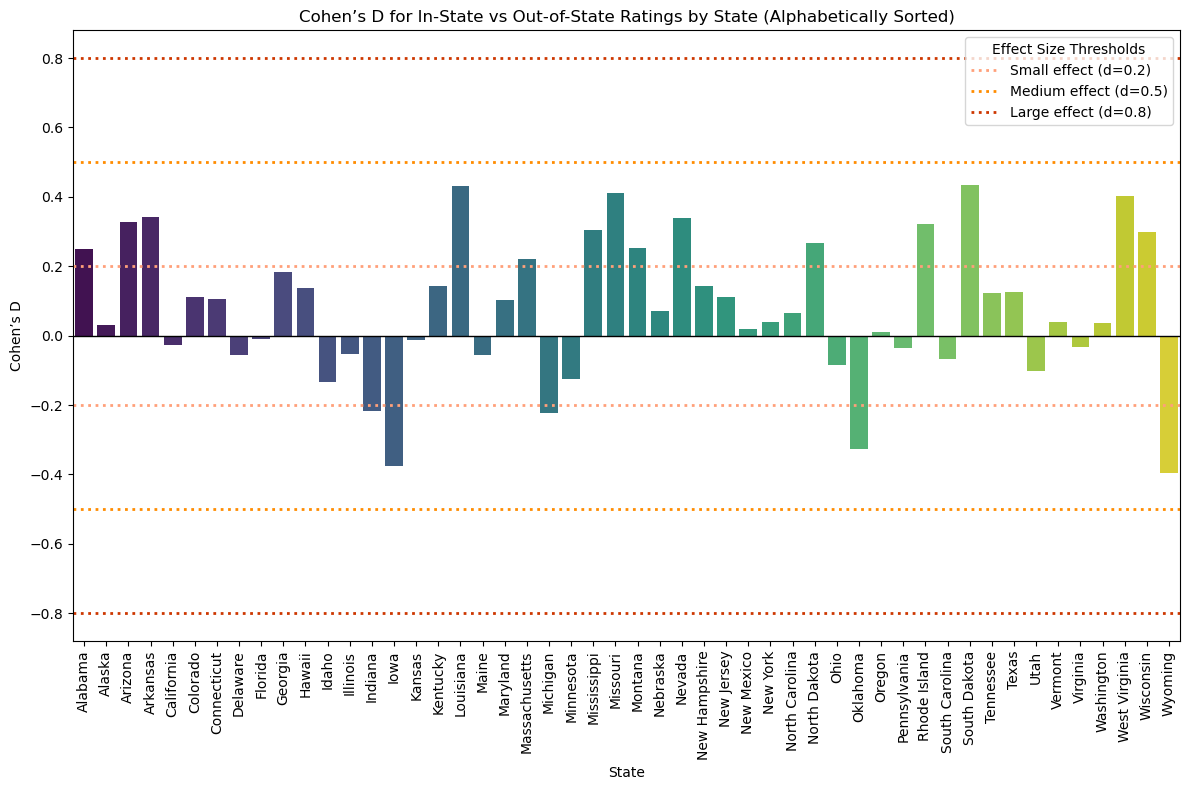

In [28]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()

# Plot 1: States sorted by Cohen's D value
plt.figure(figsize=(12, 8))
sns.barplot(
    x=cohen_df_no_nan.index, 
    y='Cohen_d', 
    data=cohen_df_no_nan, 
    palette='viridis'
)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State (Sorted by Cohen’s D)')
plt.xticks(rotation=90)
plt.legend(title='Effect Size Thresholds', loc='upper right')
plt.tight_layout()
plt.show()

# Plot 2: States sorted alphabetically
cohen_alphabetical = cohen_df_no_nan.copy()
cohen_alphabetical.sort_index(inplace=True)  # Sort by state name (index)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=cohen_alphabetical.index, 
    y='Cohen_d', 
    data=cohen_alphabetical, 
    palette='viridis'
)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State (Alphabetically Sorted)')
plt.xticks(rotation=90)
plt.legend(title='Effect Size Thresholds', loc='upper right')
plt.tight_layout()
plt.show()


for this ^ the - means that they prefer out-of-state beers and + means they prefer in-state beers

-> over 0.2 or under -0.2 and plot the difference in average 
-> you are currently looking at alabama, comparing the alabamans rating alabama beer vs non-alabamans rating alabama beer

-> next thing: alamabams rating instate beers vs rating out of state beers 

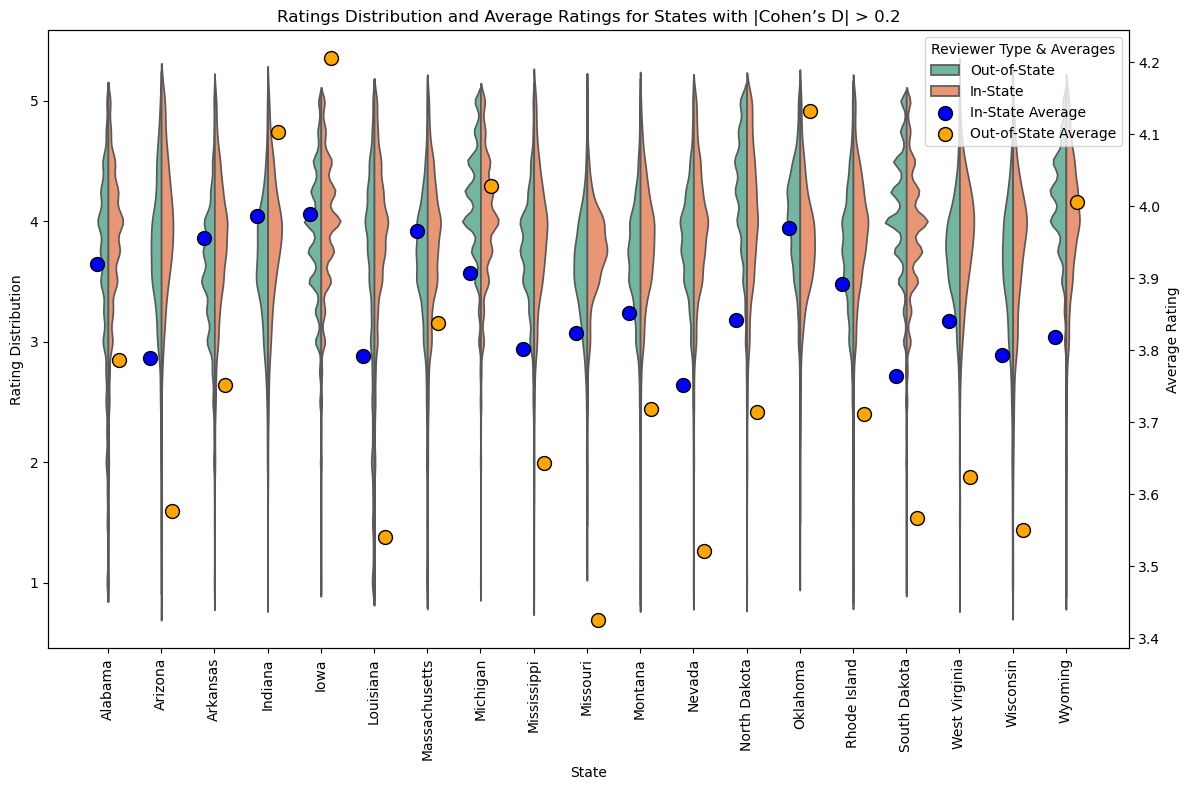

In [22]:
significant_states = cohen_df_no_nan[
    (cohen_df_no_nan['Cohen_d'] > 0.2) | (cohen_df_no_nan['Cohen_d'] < -0.2)
].index
significant_states = sorted(significant_states)

filtered_ratings = US_ratings[US_ratings['beer_state'].isin(significant_states)]

average_ratings = filtered_ratings.groupby(['beer_state', 'state_IN_VS_OUT'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 8))

ax1 = sns.violinplot(
    x='beer_state', 
    y='rating', 
    hue='state_IN_VS_OUT', 
    data=filtered_ratings, 
    split=True, 
    inner=None, 
    palette='Set2'
)

ax1.legend_.remove()

ax1.set_xlabel('State')
ax1.set_ylabel('Rating Distribution')
ax1.set_title('Ratings Distribution and Average Ratings for States with |Cohen’s D| > 0.2')

ax2 = ax1.twinx()

colors = {'In-State': 'blue', 'Out-of-State': 'orange'}

labels_added = set()  

for i, state in enumerate(significant_states):
    state_avg_ratings = average_ratings[average_ratings['beer_state'] == state]
    
    for relation, color in colors.items():
        avg_value = state_avg_ratings[state_avg_ratings['state_IN_VS_OUT'] == relation]['rating']
        if not avg_value.empty:
            x_pos = i  # Position at the state's index
            offset = -0.2 if relation == 'In-State' else 0.2
            label = f'{relation} Average' if f'{relation} Average' not in labels_added else None
            
            ax2.scatter(x_pos + offset, avg_value, 
                        color=color, 
                        edgecolor='black', 
                        s=100, 
                        zorder=3, 
                        label=label)
            if label is not None:
                labels_added.add(label)

ax2.set_ylabel('Average Rating')

ax1.set_xticks(range(len(significant_states)))  
ax1.set_xticklabels(significant_states, rotation=90)  

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines_combined, labels_combined = [], []
for l, la in zip(lines_1 + lines_2, labels_1 + labels_2):
    if la not in labels_combined:
        lines_combined.append(l)
        labels_combined.append(la)

ax1.legend(lines_combined, labels_combined, title='Reviewer Type & Averages', loc='upper right')

plt.tight_layout()
plt.show()


             state  average_in_state  average_out_of_state  difference  \
0        Wisconsin          3.793467              3.968340   -0.174872   
1           Hawaii          3.717298              3.881467   -0.164169   
2          Arizona          3.789245              3.943775   -0.154530   
3            Idaho          3.668379              3.805853   -0.137473   
4         Nebraska          3.774471              3.901185   -0.126714   
5           Nevada          3.751859              3.865740   -0.113881   
6        Louisiana          3.791667              3.894495   -0.102828   
7    New Hampshire          3.864387              3.966594   -0.102207   
8         Missouri          3.823841              3.912568   -0.088727   
9       Washington          3.811794              3.884601   -0.072807   
10            Utah          3.801265              3.873391   -0.072126   
11        Maryland          3.823831              3.895648   -0.071817   
12           Texas          3.822027  

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/3405762031.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')


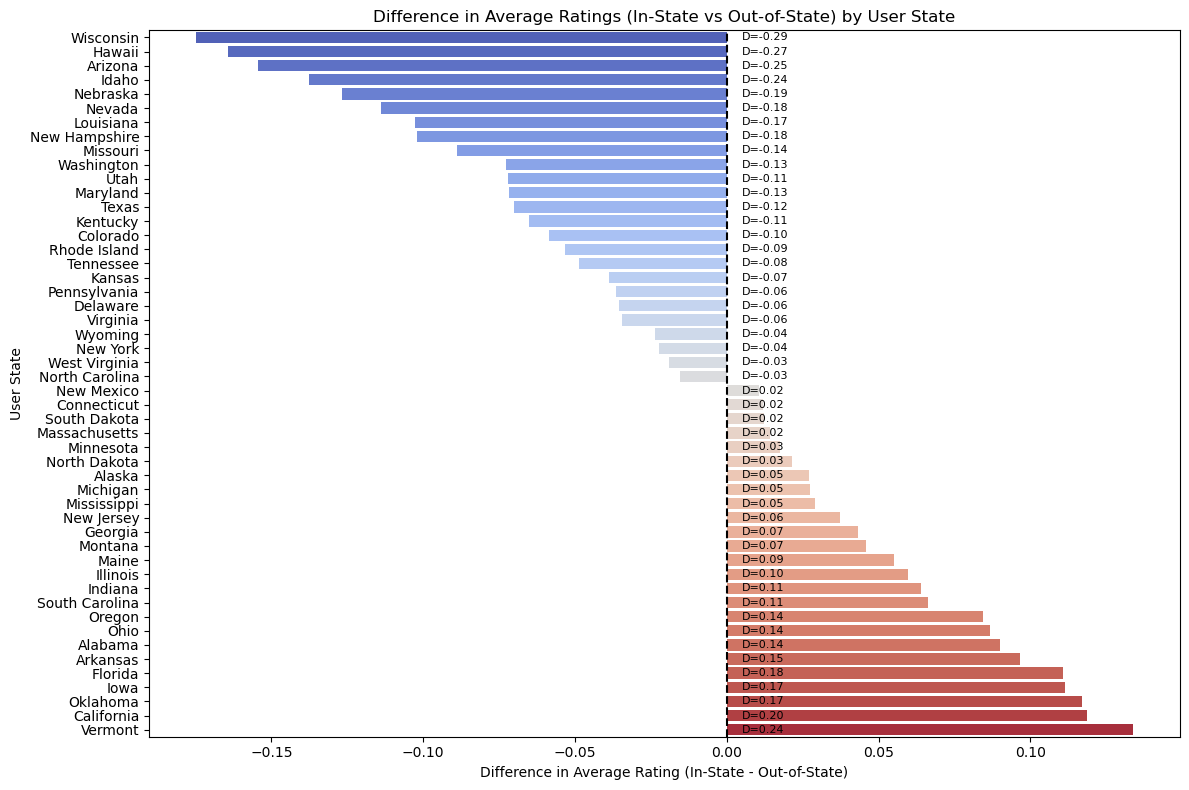

        state  average_in_state  average_out_of_state  difference   cohen_d
0   Wisconsin          3.793467              3.968340   -0.174872 -0.290529
1      Hawaii          3.717298              3.881467   -0.164169 -0.270881
2     Arizona          3.789245              3.943775   -0.154530 -0.252784
3       Idaho          3.668379              3.805853   -0.137473 -0.236599
4  California          4.013132              3.894640    0.118492  0.202219
5     Vermont          4.089329              3.955513    0.133816  0.239949


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/3405762031.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')


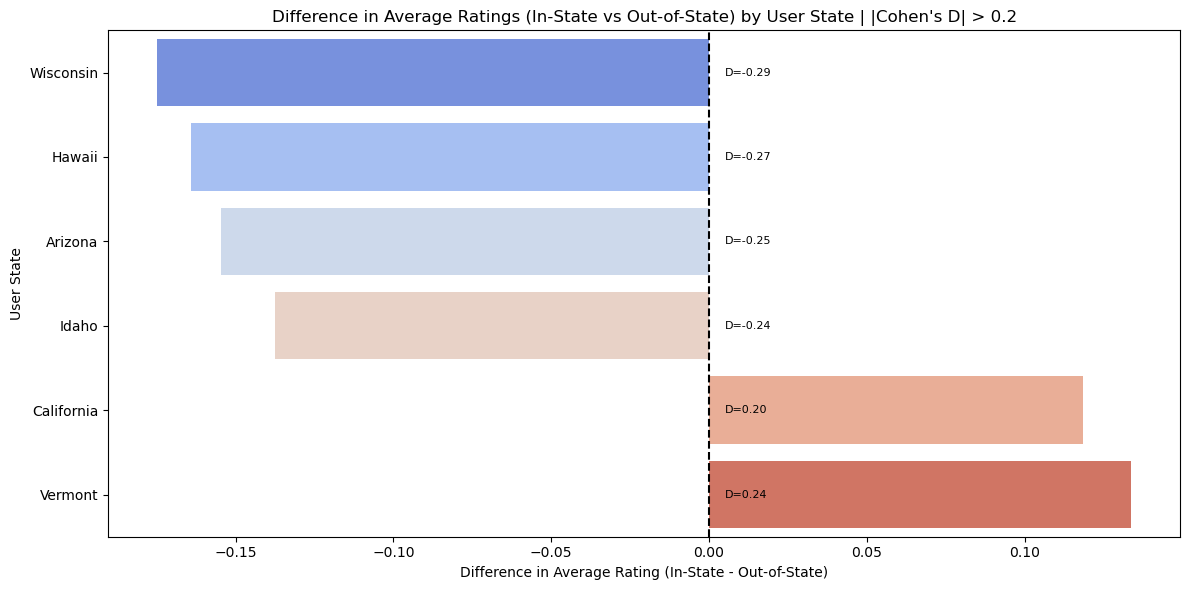

In [23]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)  # Using sample standard deviation
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['user_state'].unique()

results = []

for state in unique_states:
    state_users = US_ratings[US_ratings['user_state'] == state].copy()
    
    if state_users.empty:
        continue
    
    state_users['beer_origin'] = np.where(
        state_users['beer_state'] == state, 
        'In-State Beer', 
        'Out-of-State Beer'
    )
    
    in_state_ratings = state_users[state_users['beer_origin'] == 'In-State Beer']['rating']
    out_of_state_ratings = state_users[state_users['beer_origin'] == 'Out-of-State Beer']['rating']
    
    if in_state_ratings.empty or out_of_state_ratings.empty:
        continue
    
    average_in_state = in_state_ratings.mean()
    average_out_of_state = out_of_state_ratings.mean()
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    
    rating_diff = average_in_state - average_out_of_state
    
    results.append({
        'state': state,
        'average_in_state': average_in_state,
        'average_out_of_state': average_out_of_state,
        'difference': rating_diff,
        'cohen_d': d_value
    })

state_results = pd.DataFrame(results)
state_results.sort_values(by='difference', inplace=True)  # Sort by difference
state_results.reset_index(drop=True, inplace=True)

print(state_results)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State")
plt.ylabel("User State")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.axvline(0, color='black', linestyle='--')

for i, row in state_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax.text(text_x, i, d_val, 
            color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

filtered_results = state_results[abs(state_results['cohen_d']) > 0.2].copy()
filtered_results.sort_values(by='difference', inplace=True)
filtered_results.reset_index(drop=True, inplace=True)

print(filtered_results)

plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State | |Cohen's D| > 0.2")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.ylabel("User State")
plt.axvline(0, color='black', linestyle='--')

for i, row in filtered_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax2.text(text_x, i, d_val, 
             color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()




Questions we need to answer:

Do Texans[replace state with any state] rate their own beer higher than other US states rate Texan beer?
Do Texans[replace state with any state] rate their own beer higher than the global rating of Texan beer?


WHAT TYPE OF TEST DE WE DO to quantify the difference in average rating?
Things to consider when selecting the stat test: normality? Independence of groups? High volume of data? Large difference in number of data points for local ratings vs all other ratings?

OK we can definitively say that this data is not normally distributed!!! p value = 0.0 :(
Below I have proposed a Mann-Whitney U test but I this would work better with small datasets

In the graph the the negative scores is where the state is ranking their beer HIGHER than the US average

In [32]:
US_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,avg,user_state,beer_state,beer_origin,state_IN_VS_OUT
1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,3.76,North Carolina,Wisconsin,Out-of-State Beer,Out-of-State
1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,3.58,North Carolina,Wisconsin,Out-of-State Beer,Out-of-State
1008811,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,3.48,North Carolina,Wisconsin,Out-of-State Beer,Out-of-State
1008812,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,n2185.211743,3.25,3.75,3.50,4.25,4.25,4.00,4.02,North Carolina,Wisconsin,Out-of-State Beer,Out-of-State
1008813,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,angerhaus.1049226,4.00,4.25,3.75,4.00,4.00,4.04,4.02,Wisconsin,Wisconsin,In-State Beer,In-State


Beer styles with at least 15000 reviews:
Index(['American IPA', 'American Double / Imperial IPA',
       'American Double / Imperial Stout', 'American Pale Ale (APA)',
       'Saison / Farmhouse Ale', 'American Wild Ale', 'American Porter',
       'Russian Imperial Stout', 'American Amber / Red Ale',
       'Fruit / Vegetable Beer', 'American Brown Ale', 'American Strong Ale',
       'American Stout', 'American Pale Wheat Ale', 'Milk / Sweet Stout',
       'Witbier', 'American Barleywine', 'Pumpkin Ale', 'American Black Ale',
       'Oatmeal Stout', 'Märzen / Oktoberfest', 'Tripel',
       'American Blonde Ale', 'Scotch Ale / Wee Heavy', 'Berliner Weissbier',
       'Belgian Strong Dark Ale', 'Belgian IPA', 'Belgian Strong Pale Ale',
       'English Barleywine', 'Belgian Pale Ale', 'Hefeweizen',
       'American Adjunct Lager', 'Winter Warmer', 'American Pale Lager',
       'German Pilsener', 'Old Ale', 'Quadrupel (Quad)',
       'English India Pale Ale (IPA)', 'English Brown Ale',
   

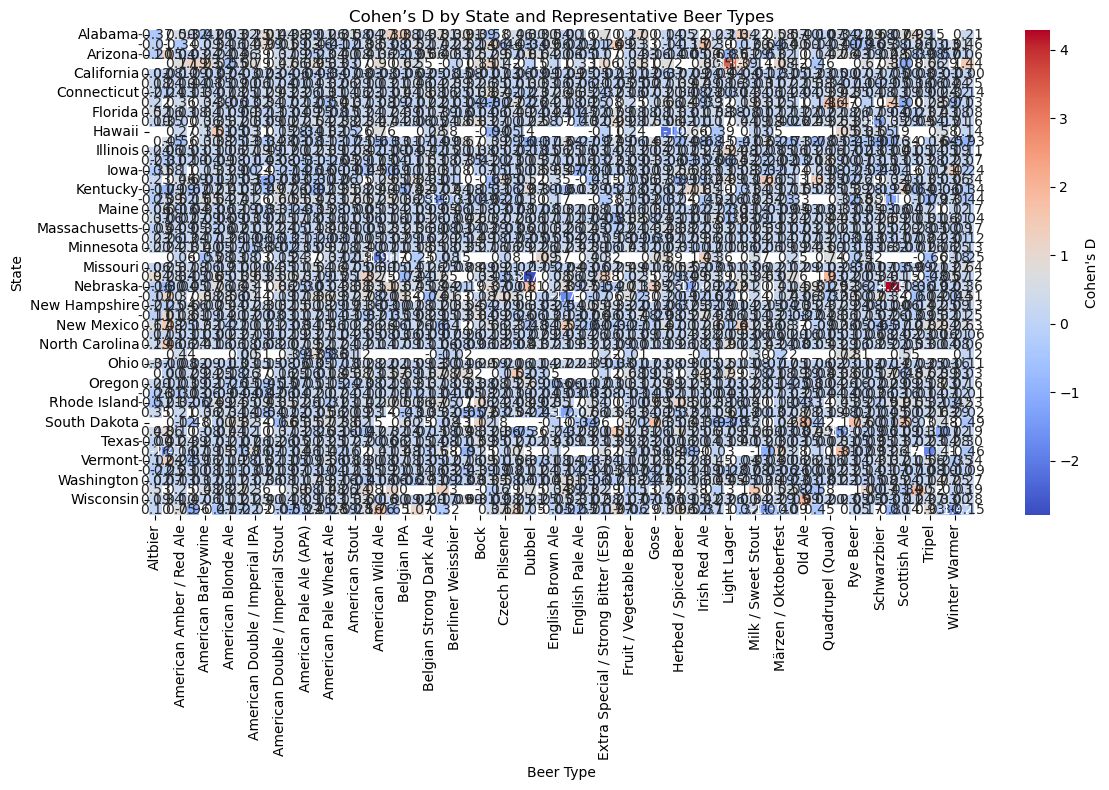

In [45]:
def cohen_d(x, y):
    x, y = np.array(x, dtype=float), np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

threshold = 15000
beer_style_counts = US_ratings['style'].value_counts()
representative_beer_styles = beer_style_counts[beer_style_counts >= threshold].index

print(f"Beer styles with at least {threshold} reviews:")
print(representative_beer_styles)
print('shape:',representative_beer_styles.size)

filtered_ratings = US_ratings[US_ratings['style'].isin(representative_beer_styles)]

unique_states = filtered_ratings['beer_state'].unique()
unique_states.sort()

cohen_results_by_type = {}

for state in unique_states:
    for b_type in representative_beer_styles:
        subset = filtered_ratings[(filtered_ratings['beer_state'] == state) & (filtered_ratings['style'] == b_type)]
        in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
        out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
        
        if len(in_state_ratings) < 2 or len(out_of_state_ratings) < 2:
            cohen_results_by_type[(state, b_type)] = np.nan
            continue
        
        d_value = cohen_d(in_state_ratings, out_of_state_ratings)
        cohen_results_by_type[(state, b_type)] = d_value

cohen_by_type_df = pd.DataFrame.from_dict(cohen_results_by_type, orient='index', columns=['Cohen_d'])
cohen_by_type_df.index = pd.MultiIndex.from_tuples(cohen_by_type_df.index, names=['State', 'Beer Type'])
cohen_by_type_df = cohen_by_type_df.reset_index()

cohen_by_type_df_no_nan = cohen_by_type_df.dropna(subset=['Cohen_d'])

heatmap_data = cohen_by_type_df_no_nan.pivot(index='State', columns='Beer Type', values='Cohen_d')

plt.figure(figsize=(12, 8))

sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': "Cohen's D"})
plt.title("Cohen’s D by State and Representative Beer Types")
plt.xlabel("Beer Type")
plt.ylabel("State")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



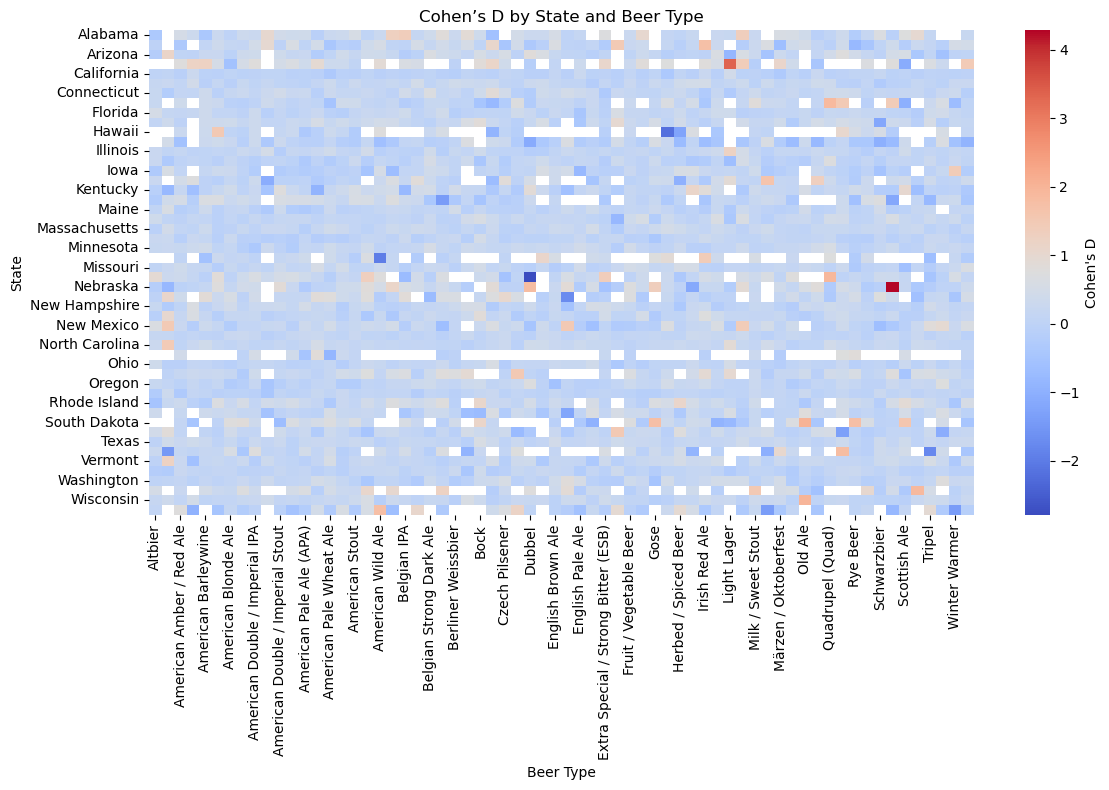

In [47]:
heatmap_data = cohen_by_type_df_no_nan.pivot(index='State', columns='Beer Type', values='Cohen_d')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': "Cohen's D"})
plt.title("Cohen’s D by State and Beer Type")
plt.xlabel("Beer Type")
plt.ylabel("State")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Explanation:

This creates a grouped bar chart where each beer type’s Cohen’s D is shown, grouped by state.

The bars above zero indicate a positive bias for that beer type and state, and those below zero indicate a negative bias.

#### Interpretation:

This chart allows you to quickly see how each state’s bias differs across various beer types.

Some states may show consistent bias across all beer types, while others might vary significantly from one beer type to another.

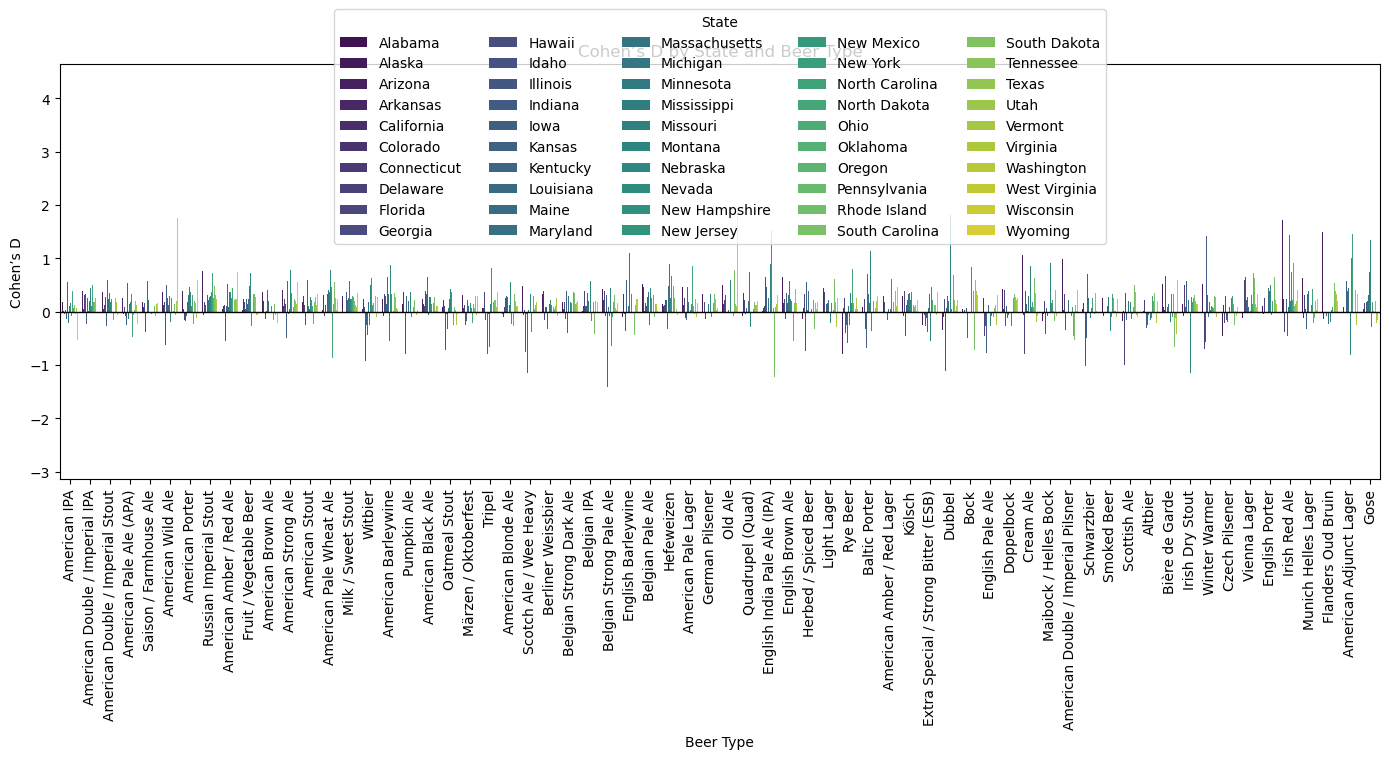

In [49]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=cohen_by_type_df_no_nan, 
    x='Beer Type', 
    y='Cohen_d', 
    hue='State',
    palette='viridis',
    dodge=True
)
plt.axhline(y=0, color='black', linewidth=1)
plt.title("Cohen’s D by State and Beer Type")
plt.xlabel("Beer Type")
plt.ylabel("Cohen’s D")
plt.xticks(rotation=90)
plt.legend(title='State', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.tight_layout()
plt.show()



In [50]:
user_state_avgs = US_ratings.groupby('user_state')['rating'].mean()
US_ratings['adjusted_rating'] = US_ratings.apply(
    lambda row: row['rating'] - user_state_avgs.get(row['user_state'], 0),
    axis=1
)


In [51]:
cohen_results_adjusted = {}

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['adjusted_rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['adjusted_rating']
    
    if len(in_state_ratings) < 2 or len(out_of_state_ratings) < 2:
        cohen_results_adjusted[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results_adjusted[state] = d_value

cohen_adjusted_df = pd.DataFrame.from_dict(cohen_results_adjusted, orient='index', columns=['Cohen_d_adjusted'])
cohen_adjusted_df.sort_values(by='Cohen_d_adjusted', inplace=True)
cohen_adjusted_df_no_nan = cohen_adjusted_df.dropna()


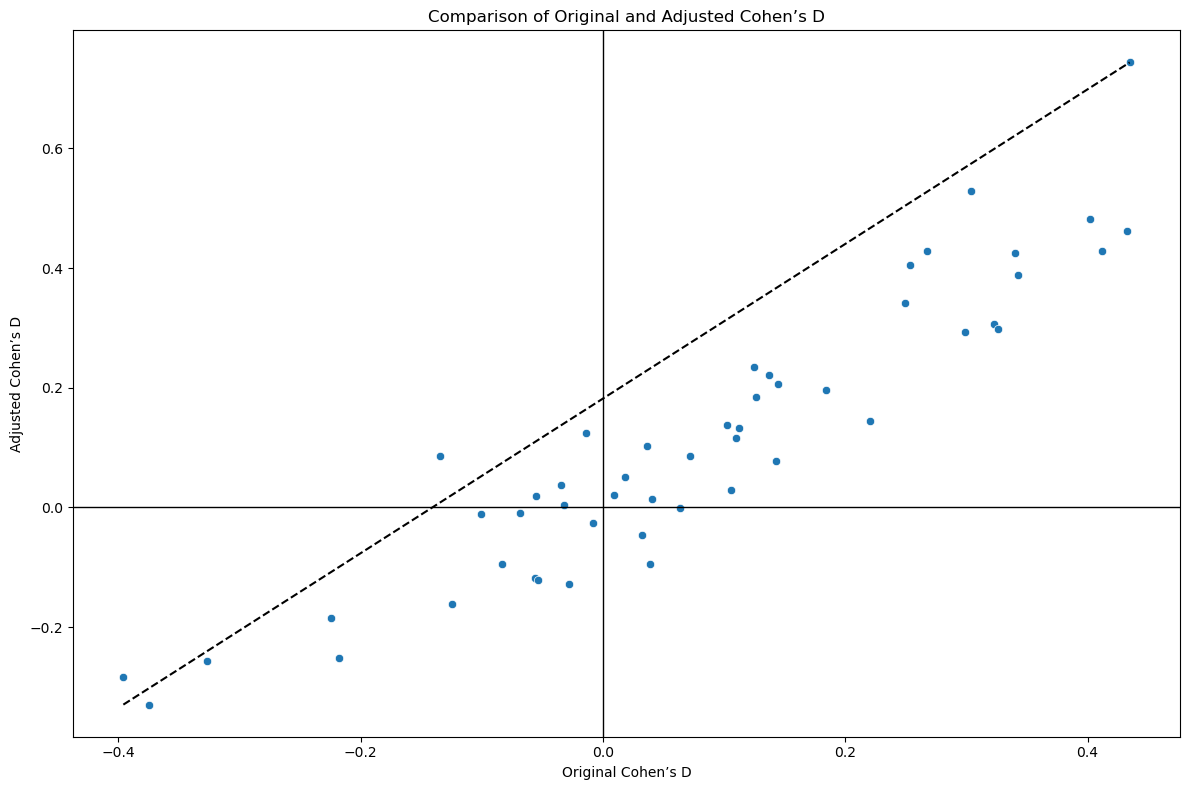

In [ ]:
merged_cohen_df = cohen_df_no_nan.join(cohen_adjusted_df_no_nan, how='inner', lsuffix='_original', rsuffix='_adjusted')

plt.figure(figsize=(12, 8))

sns.scatterplot(data=merged_cohen_df, x='Cohen_d', y='Cohen_d_adjusted')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

min_value = min(merged_cohen_df['Cohen_d'].min(), merged_cohen_df['Cohen_d_adjusted'].min())
max_value = max(merged_cohen_df['Cohen_d'].max(), merged_cohen_df['Cohen_d_adjusted'].max())
plt.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='black')

plt.xlabel('Original Cohen’s D')
plt.ylabel('Adjusted Cohen’s D')
plt.title("Comparison of Original and Adjusted Cohen’s D")
plt.tight_layout()
plt.show()

Goal: Adjust each user’s ratings by their baseline rating tendency to control for differences in how generous or strict different reviewers are when rating beers.

#### Explanation:

This scatter plot shows each state’s original Cohen’s D on the x-axis and adjusted Cohen’s D on the y-axis.
Points that deviate significantly from the diagonal line (y=x) indicate states whose biases change substantially when controlling for average rating tendencies.

Adjusted Cohen's D:

adjusted_rating is the actual rating minus the user state’s average rating, normalizing each user’s rating behavior.

#### Interpretation:

If points are close to the diagonal, adjusting for rating tendencies doesn’t change the effect size much, implying that the bias was not significantly influenced by individual rating behaviors.

If points deviate widely from the diagonal, adjusting for rating tendencies changes the observed bias, suggesting that differences in baseline rating behavior influenced the initial bias measurement.

In [53]:
beer_diff_by_state = US_ratings.groupby(['beer_state', 'beer_id']).agg({
    'rating': ['mean', 'count']
}).reset_index()

beer_diff_by_state.columns = ['beer_state', 'beer_id', 'avg_rating', 'count_ratings']


In [54]:
beer_bias_details = US_ratings.groupby(['beer_state', 'beer_id', 'state_IN_VS_OUT'])['rating'].mean().unstack(fill_value=np.nan)
beer_bias_details['rating_difference'] = beer_bias_details['In-State'] - beer_bias_details['Out-of-State']
beer_bias_details = beer_bias_details.reset_index()


In [55]:
def compute_cohens_d_for_beers(state_data):
    in_state_data = state_data[state_data['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_data = state_data[state_data['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    return cohen_d(in_state_data, out_of_state_data)

beer_consistency_results = []

for state in unique_states:
    state_data = US_ratings[US_ratings['beer_state'] == state]
    overall_cohens_d = compute_cohens_d_for_beers(state_data)
    
    beers_for_state = beer_bias_details[beer_bias_details['beer_state'] == state]
    
    # Analyze variation in rating differences across beers
    std_diff_across_beers = beers_for_state['rating_difference'].std()
    count_of_beers = beers_for_state['beer_id'].nunique()
    
    beer_consistency_results.append({
        'state': state,
        'overall_cohens_d': overall_cohens_d,
        'std_diff_across_beers': std_diff_across_beers,
        'count_of_beers': count_of_beers
    })

beer_consistency_df = pd.DataFrame(beer_consistency_results)


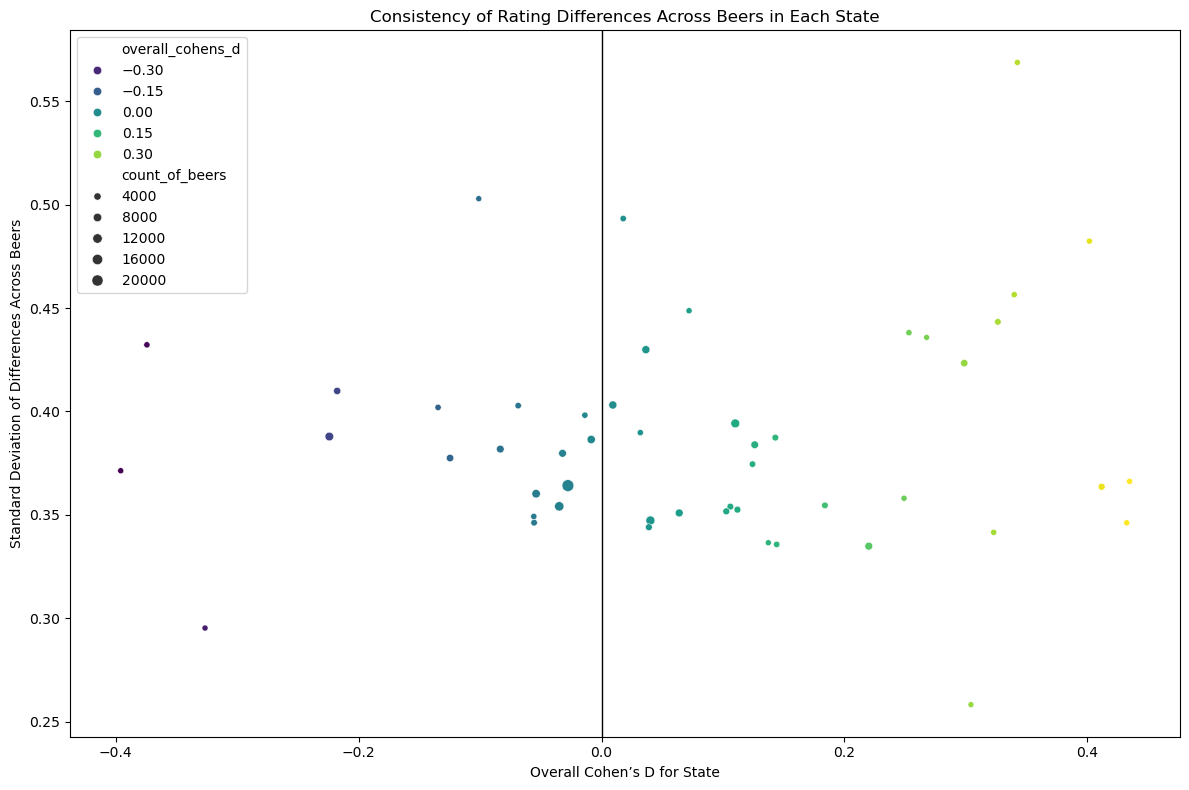

In [56]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=beer_consistency_df, x='overall_cohens_d', y='std_diff_across_beers', size='count_of_beers', hue='overall_cohens_d', palette='viridis')
plt.axvline(x=0, color='black', linewidth=1)
plt.xlabel("Overall Cohen’s D for State")
plt.ylabel("Standard Deviation of Differences Across Beers")
plt.title("Consistency of Rating Differences Across Beers in Each State")
plt.tight_layout()
plt.show()


Goal: Determine if the observed bias for each state is consistent across multiple beers or if it's driven by specific beers.

#### Explanation:

This scatter plot represents each state:
\
x-axis: The overall Cohen’s D for that state.

y-axis: The standard deviation of rating differences across beers within that state (how spread out these differences are).

The size of each point (size='count_of_beers') represents how many beers from that state are included, indicating how broad the data is.

The color (hue='overall_cohens_d') highlights the effect size difference among states.

#### Interpretation:

States with a high overall_cohens_d but a low std_diff_across_beers are consistent in their bias across all beers.

States with a high overall_cohens_d but a high std_diff_across_beers might have a few beers driving the overall bias, while others show less bias.

In [57]:
state_attributes = US_ratings.groupby('beer_state').agg(
    average_rating=('rating', 'mean'),
    count_ratings=('rating', 'count'),
    number_of_beers=('beer_id', pd.Series.nunique)  # unique beer IDs if available
).reset_index().rename(columns={'beer_state': 'state'})


In [58]:
merged = cohen_df_no_nan.join(state_attributes.set_index('state'), how='left')


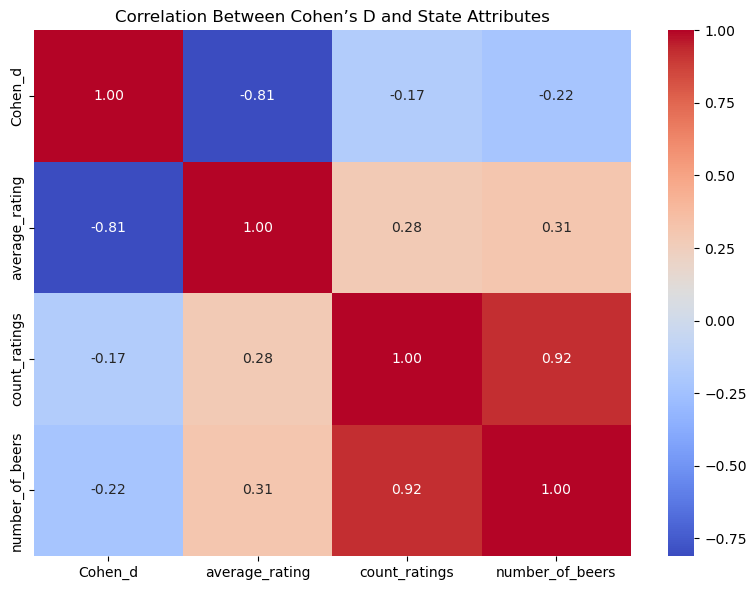

In [59]:
correlation_matrix = merged[['Cohen_d', 'average_rating', 'count_ratings', 'number_of_beers']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Cohen’s D and State Attributes")
plt.tight_layout()
plt.show()


Goal: Determine how states’ effect sizes (Cohen’s D) relate to various attributes of the states or beers, like the number of beers reviewed, average number of reviews, or a state's average rating level.

#### Explanation:

We compute the correlation matrix using corr() for the columns of interest.

sns.heatmap displays these correlations:

Positive correlations close to 1 indicate a strong positive linear relationship.

Negative correlations close to -1 indicate a strong negative linear relationship.

Annotated cells (annot=True) show correlation coefficients for clarity.

#### Interpretation:

For each state:

Cohen_d correlation with average_rating, count_ratings, and number_of_beers reveals if higher effect sizes are associated with states that have, for example, higher average ratings or more beers.

If you find a strong positive correlation between Cohen_d and number_of_beers, it might suggest that states producing more beers have a larger rating bias from in-state reviewers.

If there’s no significant correlation, it indicates these attributes do not strongly influence the bias measurement.

In [61]:
import statsmodels.api as sm

X = merged[['average_rating', 'count_ratings', 'number_of_beers']].dropna()
X = sm.add_constant(X)  # Adds a constant term to the model
Y = merged['Cohen_d'].dropna()

model = sm.OLS(Y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                Cohen_d   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     30.69
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           4.76e-11
Time:                        15:48:29   Log-Likelihood:                 36.575
No. Observations:                  50   AIC:                            -65.15
Df Residuals:                      46   BIC:                            -57.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.2910      0.455     

#### Explanation:

This fits a linear regression model predicting Cohen_d from the state attributes.
The summary displays the regression coefficients, R-squared, and significance levels.

#### Interpretation:

A significant positive coefficient for number_of_beers would indicate that, controlling for other attributes, states producing more beers have a larger effect size.
Non-significant coefficients suggest those attributes do not explain much variance in Cohen_d.